In [1]:
import numpy as np
import pandas as pd

import os

import matplotlib.pyplot as plt
import seaborn as sns

from utils.PreProcessor import PreProcessor

In [2]:
# %time preprocessor = PreProcessor(sample_num = 1, preprocess_all_raw_data = True)

In [3]:
%time preprocessor = PreProcessor(sample_num = 1, preprocess_all_raw_data = False)

**************************************
Loading PreProcessed Datasets
Loaded AirRouteDatasets
Loaded Domestic Passenger Data
Loaded Indian Railways Data
Loaded Socio-Economic Data
Loaded Monument Visitors Data
**************************************
CPU times: user 84.9 ms, sys: 5.12 ms, total: 90.1 ms
Wall time: 88.8 ms


In [4]:
def get_cost_resource_analysis(num_planes, addition_planes, forecasts, PRICE_IN, PRICE_OUT, MARKET_SHARE_IN, MARKET_SHARE_OUT, duration_in, duration_out):
    feasibility = True
    EARNINGS = []

    def inflation(price):
        return price * (1 + INFLATION_RATE / 100)
    def inflation_total(price, duration):
        return price * ((1 + INFLATION_RATE / 100) ** duration)

    current_price_in = PRICE_IN
    current_price_out = PRICE_OUT
    for year_idx, year in enumerate(np.arange(PRESENT_YEAR + 1, FORECAST_YEAR + 1)):
        num_narrow, num_turbo = num_planes[year_idx]
        year_forecasts = forecasts[forecasts['Year'] == year]
        in_demand = year_forecasts.iloc[0]['AdjustedForecastedDemand_InTraffic']
        out_demand = year_forecasts.iloc[0]['AdjustedForecastedDemand_OutTraffic']
        EARNINGS.append(
            (
                (in_demand * MARKET_SHARE_IN * current_price_in) +
                (out_demand * MARKET_SHARE_OUT * current_price_out)
            )
        )
        current_price_in = inflation(current_price_in)
        current_price_out = inflation(current_price_out)
    
    fixed_expenses_factor = 0
    operating_expenses_factor = 0
    for idx in range(FORECAST_YEAR - PRESENT_YEAR):
        operating_expenses_factor += ((duration_in + duration_out) / 60) * 365 * 2 * (num_planes[idx][0] * (CAPACITY_NARROWBODY / CAPACITY_TURBOPROP) + num_planes[idx][1]) * inflation_total(1, idx)
    for idx in range(len(addition_planes)):
        fixed_expenses_factor += (addition_planes[idx][0] * CAPACITY_NARROWBODY / CAPACITY_TURBOPROP + addition_planes[idx][1]) * inflation_total(1, FORECAST_YEAR - PRESENT_YEAR - addition_planes[idx][2])
    other_expenses_factor = 1
    total_earnings = np.sum(EARNINGS)
    
    def check_cost_equation(fixed, operating, other):
        profitability = (fixed * fixed_expenses_factor + operating * operating_expenses_factor + other_expenses_factor * other - total_earnings * (1 - PROFIT_MARGIN / 100))
        return profitability, (profitability <= 0)
    
    EXPENSES = [0] * (FORECAST_YEAR - PRESENT_YEAR)
    EXPENSES[0] += OTHER_COSTS
    current_operating_expense = OPERATING_COSTS
    for idx in range(FORECAST_YEAR - PRESENT_YEAR):
        year_operating_expense = current_operating_expense * ((duration_in + duration_out) / 60) * 365 * 2 * (num_planes[idx][0] * (CAPACITY_NARROWBODY / CAPACITY_TURBOPROP) + num_planes[idx][1])
        EXPENSES[idx] += year_operating_expense
        current_operating_expense = inflation(current_operating_expense)
    for idx in range(len(addition_planes)):
        fixed_costs = FIXED_COSTS * (addition_planes[idx][0] * CAPACITY_NARROWBODY / CAPACITY_TURBOPROP + addition_planes[idx][1]) * inflation_total(1, FORECAST_YEAR - PRESENT_YEAR - addition_planes[idx][2])
        EXPENSES[FORECAST_YEAR - PRESENT_YEAR - addition_planes[idx][2]] += fixed_costs
    
    years = np.arange(PRESENT_YEAR + 1, FORECAST_YEAR + 1)
    PROFIT_MARGIN_LIST = (np.cumsum(EARNINGS) - np.cumsum(EXPENSES)) / (np.cumsum(EARNINGS)) * 100
    
    if(check_cost_equation(FIXED_COSTS, OPERATING_COSTS, OTHER_COSTS)[1] == False):
        feasibility = False
        return feasibility, {
            'years': years,
            'EXPENSES': EXPENSES,
            'EARNINGS': EARNINGS,
            'PROFIT_MARGIN_LIST': PROFIT_MARGIN_LIST,
            'total_demands': None,
            'total_capacities': None,
            'total_flight_vacancies': None,
            'profitability_year': None
        }
    
    profitability_year = years[np.where(PROFIT_MARGIN_LIST > 0)[0][0]] - 1
    
    total_demands = []
    total_capacities = []
    total_flight_vacancies = []
    for year_idx, year in enumerate(np.arange(PRESENT_YEAR + 1, FORECAST_YEAR + 1)):
        year_forecasts = forecasts[forecasts['Year'] == year]
        total_demand = year_forecasts.iloc[0]['AdjustedForecastedDemand_InTraffic'] * MARKET_SHARE_IN + year_forecasts.iloc[0]['AdjustedForecastedDemand_OutTraffic'] * MARKET_SHARE_OUT
        total_capacity = (num_planes[year_idx][0] * CAPACITY_NARROWBODY + num_planes[year_idx][1] * CAPACITY_TURBOPROP) * 2 * 365
        total_demands.append(total_demand)
        total_capacities.append(total_capacity)
        total_flight_vacancies.append(1 - (total_demand / total_capacity))
    
    return feasibility, {
        'years': years,
        'EXPENSES': EXPENSES,
        'EARNINGS': EARNINGS,
        'PROFIT_MARGIN_LIST': PROFIT_MARGIN_LIST,
        'total_demands': total_demands,
        'total_capacities': total_capacities,
        'total_flight_vacancies': total_flight_vacancies,
        'profitability_year': profitability_year
    }

In [5]:
def plot_cost_resource_analysis(feasibility, years, EXPENSES, EARNINGS, PROFIT_MARGIN_LIST, total_demands, total_capacities, total_flight_vacancies, profitability_year):
    
    fig, ax = plt.subplots(1, 1, figsize = (20, 5))
    sns.lineplot(x = years, y = EARNINGS, label = "Earnings", ax = ax, color = 'green', linewidth = 3)
    sns.lineplot(x = years, y = EXPENSES, label = "Expenses", ax = ax, color = 'red', linewidth = 3)
    ax.fill_between(years, EARNINGS, EXPENSES, color = '#ffff0022')
    ax.legend(loc = 'best', fontsize = 10)
    ax.set_title(f"Yearly Earnings vs. Expenses", fontsize = 15)
    plt.show()
    
    fig, ax = plt.subplots(1, 1, figsize = (20, 5))
    sns.lineplot(x = years, y = np.cumsum(EARNINGS), label = "Earnings", ax = ax, color = 'green', linewidth = 3)
    sns.lineplot(x = years, y = np.cumsum(EXPENSES), label = "Expenses", ax = ax, color = 'red', linewidth = 3)
    ax.fill_between(years, np.cumsum(EARNINGS), np.cumsum(EXPENSES), color = '#ffff0022')
    ax.legend(loc = 'best', fontsize = 10)
    ax.set_title(f"Cumulative Earnings vs. Expenses", fontsize = 15)
    plt.show()
    
    fig, ax = plt.subplots(1, 1, figsize = (20, 5))
    sns.lineplot(x = years, y =PROFIT_MARGIN_LIST, linewidth = 3)
    ax.hlines(0, xmin = years[0], xmax = years[-1], color = 'black')
    if(feasibility == True):
        ax.set_title(f"Profitability forecasted in {profitability_year}", fontsize = 15)
    else:
        ax.hlines(PROFIT_MARGIN, xmin = years[0], xmax = years[-1], color = 'red')
        ax.set_title(f"Profitability cannot reach required Profit Margin", fontsize = 15)
    plt.show()
    
    if(feasibility == True):
        fig, ax = plt.subplots(1, 1, figsize = (15, 5))
        sns.lineplot(x = years, y = total_demands, label = 'Yearly Total Demand', ax = ax)
        sns.lineplot(x = years, y = total_capacities, label = 'Yearly Total Capacity', ax = ax)
        ax.legend(loc = 'best')
        ax.set_title(f"Average Flight Vacancies: {np.mean(total_flight_vacancies) * 100:.2f}%")
        plt.show()

# Cost/Resource Analysis

In [9]:
# Params

# Timeline of forecasts
FORECAST_YEAR = 2033
PRESENT_YEAR = 2023

CAPACITY_NARROWBODY = 300
CAPACITY_TURBOPROP = 100
FLEET_NARROWBODY = 3
FLEET_TURBOPROP = 2
PROFIT_MARGIN = 50
INFLATION_RATE = 7
FIXED_COSTS = 10000
OPERATING_COSTS = 1000
OTHER_COSTS = 1000000

TOP_N_COMBO = 3
MARKET_SHARE_PRICE_FACTOR = 4

#analysis_points = [*np.arange(0, FORECAST_YEAR - PRESENT_YEAR + 1, 4) + 4] + [FORECAST_YEAR - PRESENT_YEAR]
analysis_points = [3, 5, 7]

In [12]:
def get_route_feasibility(row, PRICE_IN, PRICE_OUT, NUM_IN_MARKET, PRICE_IN_MARKET, NUM_OUT_MARKET, PRICE_OUT_MARKET, SELECTED_CITY, SELECTED_HUB_AIRPORT, selected_city_airport):
    
    duration_in = row['IncomingFlightDuration']
    duration_out = row['OutgoingFlightDuration']
    forecast_file = f"./Analysis_Outputs/Forecasted_Route_Demand/City{SELECTED_CITY}_Hub{SELECTED_HUB_AIRPORT}.csv"
    forecasts = pd.read_csv(forecast_file)

    DEMAND_IN_MAX = forecasts[forecasts['Year'] == PRESENT_YEAR].iloc[0]['AdjustedForecastedDemand_InTraffic']
    DEMAND_OUT_MAX = forecasts[forecasts['Year'] == PRESENT_YEAR].iloc[0]['AdjustedForecastedDemand_OutTraffic']

    a_in = 365 * CAPACITY_NARROWBODY * (PRICE_IN_MARKET ** MARKET_SHARE_PRICE_FACTOR)
    b_in = 365 * CAPACITY_TURBOPROP * (PRICE_IN_MARKET ** MARKET_SHARE_PRICE_FACTOR)
    h_in = 365 * (CAPACITY_NARROWBODY * (PRICE_IN_MARKET ** MARKET_SHARE_PRICE_FACTOR) + CAPACITY_TURBOPROP * (PRICE_IN_MARKET ** MARKET_SHARE_PRICE_FACTOR)) / 2
    g_in = ((365 * CAPACITY_NARROWBODY * NUM_IN_MARKET * (PRICE_IN ** MARKET_SHARE_PRICE_FACTOR)) - (DEMAND_IN_MAX * (PRICE_IN_MARKET ** MARKET_SHARE_PRICE_FACTOR))) / 2
    f_in = ((365 * CAPACITY_TURBOPROP * NUM_IN_MARKET * (PRICE_IN ** MARKET_SHARE_PRICE_FACTOR)) - (DEMAND_IN_MAX * (PRICE_IN_MARKET ** MARKET_SHARE_PRICE_FACTOR))) / 2
    c_in = 0

    a_out = 365 * CAPACITY_NARROWBODY * (PRICE_OUT_MARKET ** MARKET_SHARE_PRICE_FACTOR)
    b_out = 365 * CAPACITY_TURBOPROP * (PRICE_OUT_MARKET ** MARKET_SHARE_PRICE_FACTOR)
    h_out = 365 * (CAPACITY_NARROWBODY * (PRICE_OUT_MARKET ** MARKET_SHARE_PRICE_FACTOR) + CAPACITY_TURBOPROP * (PRICE_OUT_MARKET ** MARKET_SHARE_PRICE_FACTOR)) / 2
    g_out = ((365 * CAPACITY_NARROWBODY * NUM_OUT_MARKET * (PRICE_OUT ** MARKET_SHARE_PRICE_FACTOR)) - (DEMAND_OUT_MAX * (PRICE_OUT_MARKET ** MARKET_SHARE_PRICE_FACTOR))) / 2
    f_out = ((365 * CAPACITY_TURBOPROP * NUM_OUT_MARKET * (PRICE_OUT ** MARKET_SHARE_PRICE_FACTOR)) - (DEMAND_OUT_MAX * (PRICE_OUT_MARKET ** MARKET_SHARE_PRICE_FACTOR))) / 2
    c_out = 0

    def find_solution(n_narrow, n_turbo, a, b, h, g, f, c):
        return ((a*(n_narrow ** 2)) + (b*(n_turbo ** 2)) + 2*h*n_narrow*n_turbo + 2*g*n_narrow + 2*f*n_turbo + c > 0)

    solutions_in = []
    for n_narrow in np.arange(0, FLEET_NARROWBODY + 1):
        for n_turbo in np.arange(0, FLEET_TURBOPROP + 1):
            if(find_solution(n_narrow, n_turbo, a_in, b_in, h_in, g_in, f_in, c_in)):
                solutions_in.append((n_narrow, n_turbo))

    solutions_out = []
    for n_narrow in np.arange(0, FLEET_NARROWBODY + 1):
        for n_turbo in np.arange(0, FLEET_TURBOPROP + 1):
            if(find_solution(n_narrow, n_turbo, a_out, b_out, h_out, g_out, f_out, c_out)):
                solutions_out.append((n_narrow, n_turbo))

    feasible = True
    if(len(solutions_in) == 0):
        print("NOT FEASIBLE!")
        feasible = False

    if(len(solutions_out) == 0):
        print("NOT FEASIBLE!")
        feasible = False

    if(feasible == True):
        solutions = list(set(solutions_in).intersection(set(solutions_out)))
        sorted_combos = sorted(solutions, key = lambda x: CAPACITY_NARROWBODY * x[0] + CAPACITY_TURBOPROP * x[1])
        NUM_NARROW, NUM_TURBOPROP = sorted_combos[0]

        assert(a_in * (NUM_NARROW ** 2) + b_in * (NUM_TURBOPROP ** 2) + 2 * h_in * NUM_NARROW * NUM_TURBOPROP + 2 * g_in * NUM_NARROW + 2 * f_in * NUM_TURBOPROP + c_in > 0)
        assert(a_out * (NUM_NARROW ** 2) + b_out * (NUM_TURBOPROP ** 2) + 2 * h_out * NUM_NARROW * NUM_TURBOPROP + 2 * g_out * NUM_NARROW + 2 * f_out * NUM_TURBOPROP + c_out > 0)

        MARKET_SHARE_IN = ((NUM_NARROW + NUM_TURBOPROP) / (PRICE_IN ** MARKET_SHARE_PRICE_FACTOR)) / (((NUM_NARROW + NUM_TURBOPROP) / (PRICE_IN ** MARKET_SHARE_PRICE_FACTOR)) + (NUM_IN_MARKET / (PRICE_IN_MARKET ** MARKET_SHARE_PRICE_FACTOR)))
        MARKET_SHARE_OUT = ((NUM_NARROW + NUM_TURBOPROP) / (PRICE_OUT ** MARKET_SHARE_PRICE_FACTOR)) / (((NUM_NARROW + NUM_TURBOPROP) / (PRICE_OUT ** MARKET_SHARE_PRICE_FACTOR)) + (NUM_OUT_MARKET / (PRICE_OUT_MARKET ** MARKET_SHARE_PRICE_FACTOR)))
    else:
        MARKET_SHARE_IN = 0
        MARKET_SHARE_OUT = 0

#     print(f"Entry into market with {NUM_NARROW + NUM_TURBOPROP} flight(s)!")
#     print()
#     print("Estimated Market Share:")
#     print(f"Incoming Flights: {MARKET_SHARE_IN * 100:.1f}%\nOutgoing Flights: {MARKET_SHARE_OUT * 100:.1f}%")

    DEMAND_IN_MAX_LIST = np.zeros(FORECAST_YEAR - PRESENT_YEAR + 1)
    DEMAND_OUT_MAX_LIST = np.zeros(FORECAST_YEAR - PRESENT_YEAR + 1)
    DEMAND_IN_MAX = 0
    DEMAND_OUT_MAX = 0
    count_list = []
    year_idx_list = []
    count = 0

    for year_idx, year in enumerate(np.arange(PRESENT_YEAR + 1, FORECAST_YEAR + 2)):

        if(year_idx in analysis_points):

            DEMAND_IN_MAX_LIST[year_idx] = DEMAND_IN_MAX
            DEMAND_OUT_MAX_LIST[year_idx] = DEMAND_OUT_MAX
            count_list.append(count)
            year_idx_list.append(year_idx)

            count = 0
            DEMAND_IN_MAX = 0
            DEMAND_OUT_MAX = 0

        if(year <= FORECAST_YEAR):
            year_forecasts = forecasts[forecasts['Year'] == year]
            in_demand = year_forecasts.iloc[0]['AdjustedForecastedDemand_InTraffic']
            out_demand = year_forecasts.iloc[0]['AdjustedForecastedDemand_OutTraffic']
            if(in_demand > DEMAND_IN_MAX):
                DEMAND_IN_MAX = in_demand
            if(out_demand > DEMAND_OUT_MAX):
                DEMAND_OUT_MAX = out_demand
            count += 1

    def add_to_deepest_list(a, b):
        if(type(b) == list):
            if(type(b[0]) == list):
                return [add_to_deepest_list(a, x) for x in b]
            else:
                assert(type(b[0]) == tuple)
                return [a] + b

    def find_solution(n_narrow, n_turbo, a, b, h, g, f, c):
        return ((a*(n_narrow ** 2)) + (b*(n_turbo ** 2)) + 2*h*n_narrow*n_turbo + 2*g*n_narrow + 2*f*n_turbo + c > 0)

    def get_num_planes(year_idx, prev_num_narrowbody, prev_num_turbo):
        if(year_idx in analysis_points):

            DEMAND_IN_MAX = DEMAND_IN_MAX_LIST[year_idx]
            DEMAND_OUT_MAX = DEMAND_OUT_MAX_LIST[year_idx]

            a_in = 0
            b_in = 0
            h_in = 0
            g_in = 365 * (CAPACITY_NARROWBODY) / 2
            f_in = 365 * (CAPACITY_TURBOPROP) / 2
            c_in = -MARKET_SHARE_IN * DEMAND_IN_MAX

            a_out = 0
            b_out = 0
            h_out = 0
            g_out = 365 * (CAPACITY_NARROWBODY) / 2
            f_out = 365 * (CAPACITY_TURBOPROP) / 2
            c_out = -MARKET_SHARE_OUT * DEMAND_OUT_MAX

            solutions_in = []
            for n_narrow in np.arange(prev_num_narrowbody, FLEET_NARROWBODY + 1):
                for n_turbo in np.arange(prev_num_turbo, FLEET_TURBOPROP + 1):
                    if(find_solution(n_narrow, n_turbo, a_in, b_in, h_in, g_in, f_in, c_in)):
                        solutions_in.append((n_narrow, n_turbo))

            solutions_out = []
            for n_narrow in np.arange(prev_num_narrowbody, FLEET_NARROWBODY + 1):
                for n_turbo in np.arange(prev_num_turbo, FLEET_TURBOPROP + 1):
                    if(find_solution(n_narrow, n_turbo, a_out, b_out, h_out, g_out, f_out, c_out)):
                        solutions_out.append((n_narrow, n_turbo))

            if(len(solutions_in) == 0):
#                 print("ALERT!")
                solutions_in = [(-1, -1)]
                feasible = False

            if(len(solutions_out) == 0):
#                 print("ALERT!")
                solutions_out = [(-1, -1)]
                feasible = False

            solutions = list(set(solutions_in).intersection(set(solutions_out)))
            if(len(solutions) == 0):
#                 print("ALERT! No common combos found!")
                solutions = [(-1, -1)]
            solutions = sorted(solutions, key = lambda x: CAPACITY_NARROWBODY * x[0] + CAPACITY_TURBOPROP * x[1])[:TOP_N_COMBO]

            all_solutions = []
            for solution in solutions:
                if(year_idx == analysis_points[-1]):
                    all_solutions.append([solution])
                else:
                    all_solutions.append(add_to_deepest_list((solution[0], solution[1]), get_num_planes(year_idx + 1, solution[0], solution[1])))
            return all_solutions
        else:
            return get_num_planes(year_idx + 1, prev_num_narrowbody, prev_num_turbo)

    all_combos = get_num_planes(0, 0, 0)
    def flatten(x, all_combos):
        if(type(x) == list):
            if(type(x[0]) == tuple):
                all_combos.append(x)
            else:
                for y in x:
                    all_combos = flatten(y, all_combos)
        return all_combos

    all_combos = flatten(all_combos, [])
    all_combos = [x for x in all_combos if np.any([(y[0] == (-1)) | (y[1] == (-1)) for y in x]) == False]

    num_planes_all_combos = []
    addition_planes_all_combos = []
    for combo in all_combos:
        num_planes = [(0, 0)]
        addition_planes = []
        for count_idx, count in enumerate(count_list):
            addition_planes.append((combo[count_idx][0] - num_planes[-1][0], combo[count_idx][1] - num_planes[-1][1], (FORECAST_YEAR - PRESENT_YEAR - year_idx_list[count_idx]) + count_list[count_idx]))
            num_planes.extend([combo[count_idx]] * count)
        num_planes_all_combos.append(num_planes[1:])
        addition_planes_all_combos.append(addition_planes)
    
    combo_info = []
    for combo_idx in range(len(num_planes_all_combos)):
        num_planes = num_planes_all_combos[combo_idx]
        addition_planes = addition_planes_all_combos[combo_idx]
        feasibility, cost_resource_analysis = get_cost_resource_analysis(num_planes, addition_planes, forecasts, PRICE_IN, PRICE_OUT, MARKET_SHARE_IN, MARKET_SHARE_OUT, duration_in, duration_out)
    #     if(feasibility):
    #         print(num_planes)
    #         plot_cost_resource_analysis(feasibility, **cost_resource_analysis)
        combo_info.append({'num_planes': num_planes, 'feasibility': feasibility, 'cost_resource_analysis': cost_resource_analysis})
    
    return {'Solutions': combo_info, 'OtherInfo': {
        'MARKET_SHARE_IN': MARKET_SHARE_IN,
        'MARKET_SHARE_OUT': MARKET_SHARE_OUT
    }}

In [13]:
route_df = pd.read_csv('./Analysis_Outputs/most_growth_routes.csv')

analysis_points = analysis_points + [FORECAST_YEAR - PRESENT_YEAR]
all_route_combo_info = {}
city_to_airport_mapping = dict(zip(preprocessor.city_mapping['City'].values, preprocessor.city_mapping['AirRouteData_AirportCode'].values))
for idx, row in route_df.iterrows():
    
    SELECTED_CITY = row['City']
    SELECTED_HUB_AIRPORT = row['Hub']
    print()
    print(SELECTED_CITY, SELECTED_HUB_AIRPORT)
    selected_city_airport = city_to_airport_mapping[SELECTED_CITY]
    
    route_network_data_out = preprocessor.all_network_data[(preprocessor.all_network_data['From'] == selected_city_airport) & (preprocessor.all_network_data['To'] == SELECTED_HUB_AIRPORT)]
    route_network_data_in = preprocessor.all_network_data[(preprocessor.all_network_data['To'] == selected_city_airport) & (preprocessor.all_network_data['From'] == SELECTED_HUB_AIRPORT)]

    if(route_network_data_out.shape[0] == 0):
        #print("Market Price is not known!")
        NUM_OUT_MARKET = 0
        PRICE_OUT_MARKET = -1 # Don't care
        pass
    else:
        PRICE_OUT_MARKET = route_network_data_out['Cheapest Price'].mean()
        NUM_OUT_MARKET = int(route_network_data_out['Number of Flights'].sum())
        print(f"No. of existing outgoing Flights: {NUM_OUT_MARKET}\nMarket Price: ${PRICE_OUT_MARKET:.1f}")
    #print()
    if(route_network_data_in.shape[0] == 0):
        #print("Market Price is not known!")
        NUM_IN_MARKET = 0
        PRICE_IN_MARKET = -1 # Don't care
        pass
    else:
        PRICE_IN_MARKET = route_network_data_in['Cheapest Price'].mean()
        NUM_IN_MARKET = int(route_network_data_in['Number of Flights'].sum())
        print(f"No. of existing incoming Flights: {NUM_IN_MARKET}\nMarket Price: ${PRICE_IN_MARKET:.1f}")
    
    PRICE_IN = int(input("Enter price for incoming flight: "))
    PRICE_OUT = int(input("Enter price for outgoing flight: "))
    
    route_info = get_route_feasibility(row, PRICE_IN, PRICE_OUT, NUM_IN_MARKET, PRICE_IN_MARKET, NUM_OUT_MARKET, PRICE_OUT_MARKET, SELECTED_CITY, SELECTED_HUB_AIRPORT, selected_city_airport)
    route_info['OtherInfo']['PRICE_IN'] = PRICE_IN
    route_info['OtherInfo']['PRICE_OUT'] = PRICE_OUT
    route_info['OtherInfo']['PRICE_IN_MARKET'] = PRICE_IN_MARKET
    route_info['OtherInfo']['PRICE_OUT_MARKET'] = PRICE_OUT_MARKET
    route_info['OtherInfo']['NUM_IN_MARKET'] = NUM_IN_MARKET
    route_info['OtherInfo']['NUM_OUT_MARKET'] = NUM_OUT_MARKET
    all_route_combo_info[f"{SELECTED_CITY}_{SELECTED_HUB_AIRPORT}"] = route_info
    
    num_feasible_plans = 0
    for combo in route_info['Solutions']:
        if(combo['feasibility'] == True):
            num_feasible_plans += 1
    print(f"Market Share: {route_info['OtherInfo']['MARKET_SHARE_IN'] * 100:.1f}%, {route_info['OtherInfo']['MARKET_SHARE_IN'] * 100:.1f}")
    print(num_feasible_plans)


Bhopal BLR
No. of existing outgoing Flights: 2
Market Price: $78.0
No. of existing incoming Flights: 2
Market Price: $64.0
Enter price for incoming flight: 60
Enter price for outgoing flight: 60
Market Share: 39.3%, 39.3
0

Bhopal HYD
No. of existing outgoing Flights: 1
Market Price: $190.0
No. of existing incoming Flights: 1
Market Price: $110.0
Enter price for incoming flight: 100
Enter price for outgoing flight: 200
Market Share: 59.4%, 59.4
1

Bhopal BOM
No. of existing outgoing Flights: 3
Market Price: $57.0
No. of existing incoming Flights: 3
Market Price: $64.0
Enter price for incoming flight: 80
Enter price for outgoing flight: 80
Market Share: 12.0%, 12.0
0

Bhopal CCU
Enter price for incoming flight: 1
Enter price for outgoing flight: 1
Market Share: 100.0%, 100.0
0

Bhopal DEL
No. of existing outgoing Flights: 4
Market Price: $49.0
No. of existing incoming Flights: 4
Market Price: $47.0
Enter price for incoming flight: 50
Enter price for outgoing flight: 50
Market Share: 28

/tmp/ipykernel_94744/1343684397.py:51: RuntimeWarning: divide by zero encountered in divide
  PROFIT_MARGIN_LIST = (np.cumsum(EARNINGS) - np.cumsum(EXPENSES)) / (np.cumsum(EARNINGS)) * 100


In [15]:
for route in all_route_combo_info:
    num_feasible_plans = 0
    for combo in all_route_combo_info[route]['Solutions']:
        if(combo['feasibility'] == True):
            num_feasible_plans += 1
    print(route, num_feasible_plans)

Bhopal_BLR 0
Bhopal_HYD 1
Bhopal_BOM 0
Bhopal_CCU 0
Bhopal_DEL 0
Pune_BLR 0
Pune_HYD 0
Pune_BOM 0
Pune_CCU 0
Pune_DEL 0
Thiruvananthapuram_BLR 0
Thiruvananthapuram_HYD 0
Thiruvananthapuram_BOM 0
Thiruvananthapuram_CCU 28
Thiruvananthapuram_DEL 0
Visakhapatnam_BLR 0
Visakhapatnam_HYD 0
Visakhapatnam_BOM 0
Visakhapatnam_CCU 0
Visakhapatnam_DEL 0
Lucknow_BLR 0
Lucknow_HYD 0
Lucknow_BOM 0
Lucknow_CCU 0
Lucknow_DEL 0


[(1, 2), (1, 2), (1, 2), (1, 2), (1, 2), (2, 2), (2, 2), (3, 2), (3, 2), (3, 2)]
1000 1000
1.0 1.0
-1 -1
0 0


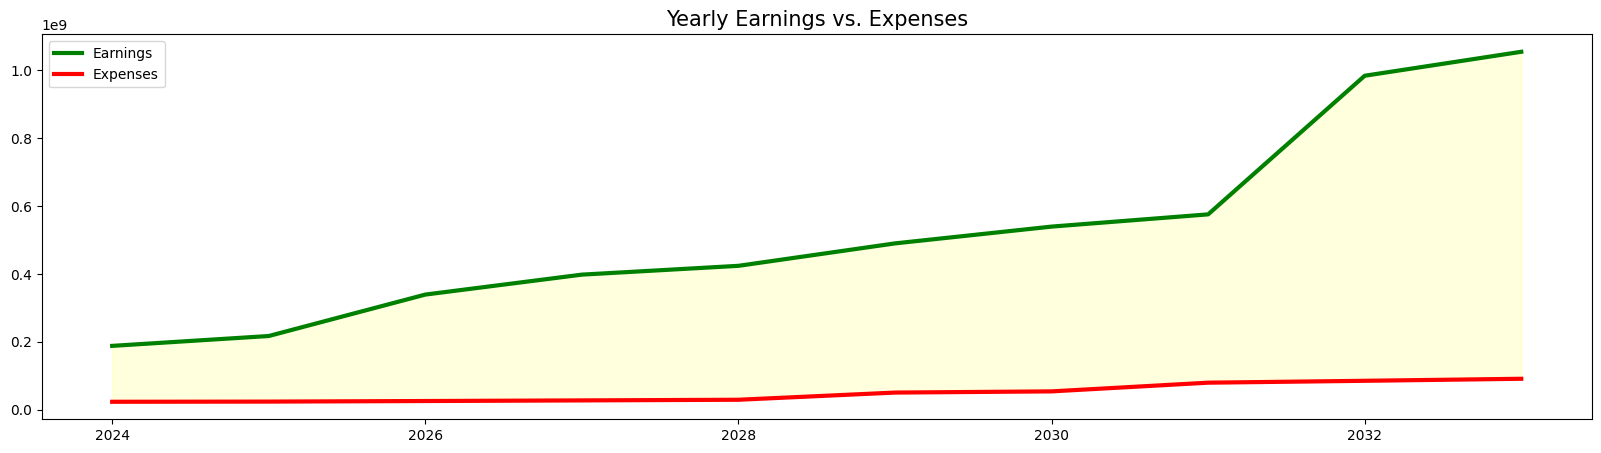

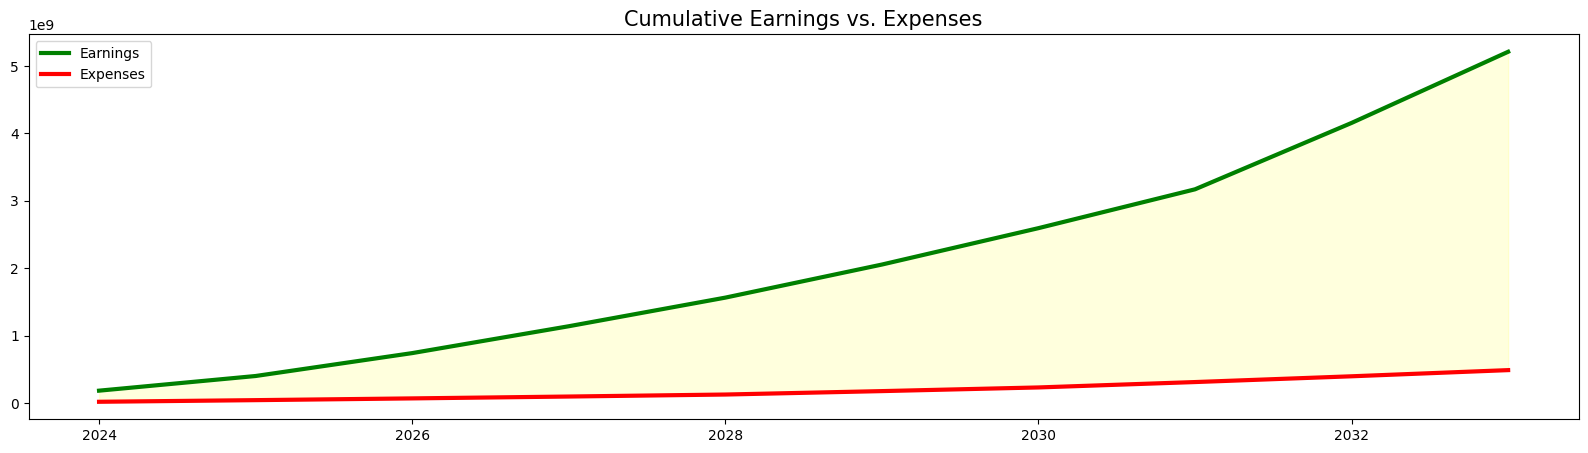

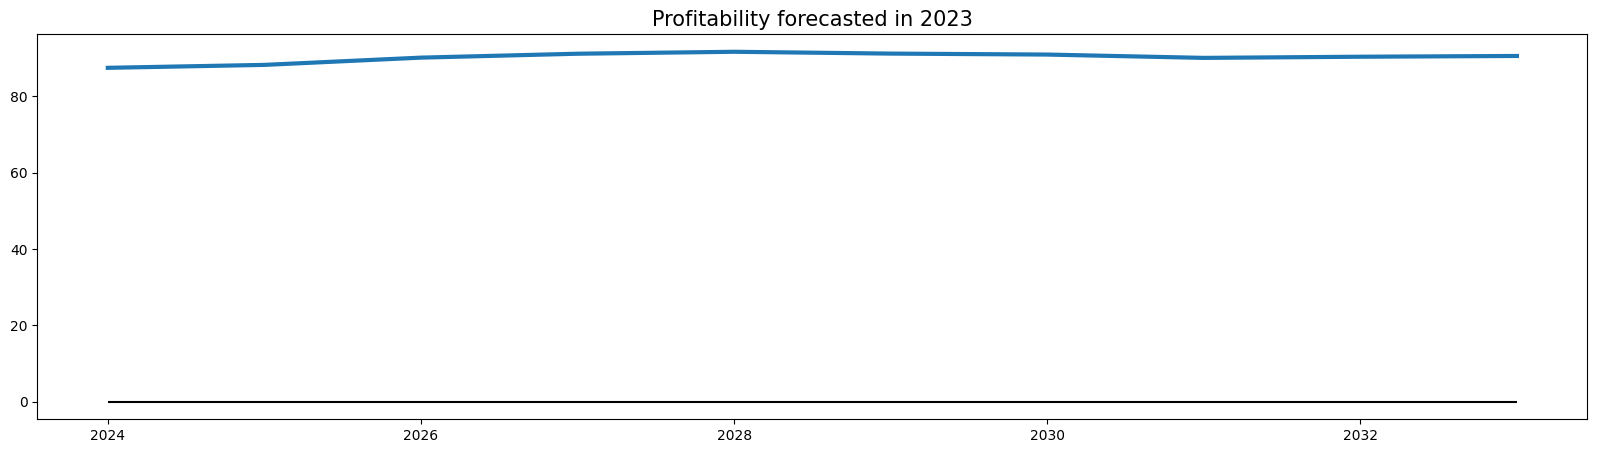

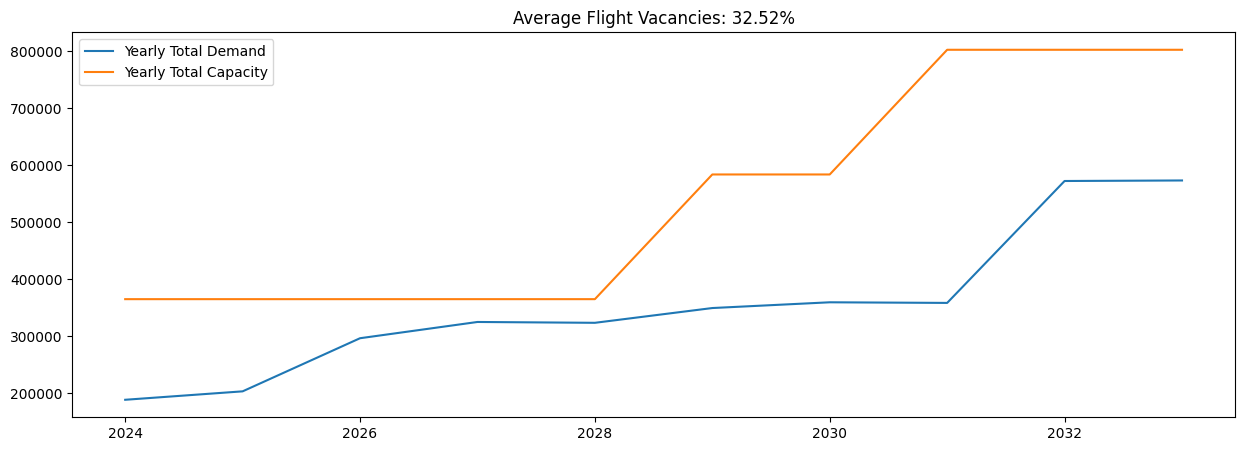

In [22]:
route = 'Thiruvananthapuram_CCU'
sample_route_info = [x for x in all_route_combo_info[route]['Solutions'] if x['feasibility'] == True][0]
print(sample_route_info['num_planes'])
print(all_route_combo_info[route]['OtherInfo']['PRICE_IN'], all_route_combo_info[route]['OtherInfo']['PRICE_OUT'])
print(all_route_combo_info[route]['OtherInfo']['MARKET_SHARE_IN'], all_route_combo_info[route]['OtherInfo']['MARKET_SHARE_OUT'])
print(all_route_combo_info[route]['OtherInfo']['PRICE_IN_MARKET'], all_route_combo_info[route]['OtherInfo']['PRICE_OUT_MARKET'])
print(all_route_combo_info[route]['OtherInfo']['NUM_IN_MARKET'], all_route_combo_info[route]['OtherInfo']['NUM_OUT_MARKET'])
plot_cost_resource_analysis(sample_route_info['feasibility'], **sample_route_info['cost_resource_analysis'])